In [2]:
# common library
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import argparse
import json
import cv2

# torch library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

# import my file
from lib.data_utils import test

1-10是simulator的数据集，11-14是Intraoperative的数据集

In [34]:

# base path 
base_path = 'Traindata/'
# simulator data set
simulator_num = [i+1 for i in range(10)]
s_tmp = '1'
simulator_path = base_path + 'aicm'+s_tmp+'/VID000_0'
# intraoperative data set
intra_num = [11, 12, 13, 14]
i_tmp = '11'
intra_path = 'aicm' + i_tmp

images_path = simulator_path + '/images'
labels_path = simulator_path + '/point_labels'

print(images_path)
print(labels_path)

Traindata/aicm1/VID000_0/images
Traindata/aicm1/VID000_0/point_labels


In [46]:
images_name = os.listdir(images_path)
labels_name = os.listdir(labels_path)
file_name = []
for i in images_name:
    file_name.append(i.split(".")[0])
#     print(i.split(".")[0])
# print(file_name)
# print(images_name)
# print(labels_name)




In [11]:
test()

I am in utils


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cv2



# target = np.zeros((288, 512))
# plt.imshow(target, cmap='hot', interpolation='nearest')
# plt.show()
# target = generate_heatmap(target, (15, 15))
# plt.imshow(target, cmap='hot', interpolation='nearest')
# plt.show()
# # print(target)

In [36]:
def generate_heatmap(img, x, y, sigma=(15,15)):
    img[x][y] = 1
    img = cv2.GaussianBlur(img, sigma, 2)
    am = np.amax(img)
    img /= am / 255
    heatmap = img
    return heatmap



def heatmap_generator(file_name):
    file_in = json.load(open(file_name))
    points = file_in["points"]
    point_outs = []
    height = file_in["imageHeight"]
    width = file_in["imageWidth"]
    img = np.zeros((height,width,3),dtype = np.uint8)
    for point in points:
        point_out = []
        point_out.append(point["x"])
        point_out.append(point["y"])
        point_outs.append(point_out)
    
    x, y = point_outs[0]
    img = generate_heatmap(img, x, y)

    img_show = Image.fromarray(img,"RGB")
    img_show.show()
    img_show.save("./pic/heatmap.png")



In [1]:
import json
import glob
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

def generate_mask(img_height,img_width,radius,center_x,center_y):
    y,x=np.ogrid[0:img_height,0:img_width]
    # circle mask
    mask = (x-center_x)**2+(y-center_y)**2<=radius**2
    return mask

def label2mask(file_name):
    file_in = json.load(open(file_name))
    points = file_in["points"]
    point_outs = []
    height = file_in["imageHeight"]
    width = file_in["imageWidth"]
    img = np.zeros((height,width),dtype = np.uint8)
    for point in points:
        point_out = []
        point_out.append(point["x"])
        point_out.append(point["y"])
        point_outs.append(point_out)
    # circles = []
    # # 画圆
    # for a in point_outs:
    #     masks = generate_mask(height,width,1,a[1],a[0])
    #     xs,ys = np.where(masks == True)
    #     for i in range(len(xs)):
    #         circle = []
    #         circle.append(xs[i])
    #         circle.append(ys[i])
    #         circles.append(circle)
    for b in point_outs:
        img[b[1],b[0]] = 255
    return img

class Medical_Data(Dataset):
    def __init__(self, data_path, data_mode, set_mode):
        '''
        data_path: data path
        data_mode: simulator or intra data
        set_mode:  train or test
        '''
        self.data_path = data_path
        if data_mode == "simulator":
            self.imgs_path = glob.glob(os.path.join(data_path,"aicm[1-9]/*/images/*.png"))
            self.imgs_path += glob.glob(os.path.join(data_path,"aicm10/*/images/*.png"))
        elif data_mode == "intra":
            self.imgs_path = glob.glob(os.path.join(data_path,"aicm1[1-4]/*/images/*.png"))

        print('Finished reading the {}_{} set of medical dataset ({} samples found)'
            .format(data_mode, set_mode, len(self.imgs_path)))

    def augment(self, image, code):
        print("data augment")

    def __getitem__(self, index):
        image_path = self.imgs_path[index]
        label_path = image_path.replace("images","point_labels").replace(".png",".json")
        img = Image.open(image_path)
        transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean，标准差
        ])

        image = transform(img)
        l = Image.fromarray(np.uint8(label2mask(label_path)))
        label = transform(l)

        # image = torch.from_numpy(np.array(img)) 
        # image = image.permute(2, 0, 1)
        # label = torch.from_numpy(label2mask(label_path))

        return image,label

    def __len__(self):
        return len(self.imgs_path)

In [27]:
def im_convert(tensor, ifimg):
    """ 展示数据"""
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    if ifimg:
        image = image.transpose(1,2,0)
    return image

simulator_dataset = Medical_Data("./Traindata/","simulator","test")
intra_dataset = Medical_Data("./Traindata/","intra","test")
simulator_loader = torch.utils.data.DataLoader(dataset=simulator_dataset,
                                           batch_size=1, 
                                           shuffle=True)

dataiter = iter(simulator_loader)
images, labels = dataiter.next()
# print(images.shape)
# print(labels.shape)
# print(images)
# print(labels)
image = im_convert(images, True)
label = im_convert(labels, False)


Finished reading the simulator_test set of medical dataset (2708 samples found)
Finished reading the intra_test set of medical dataset (2376 samples found)


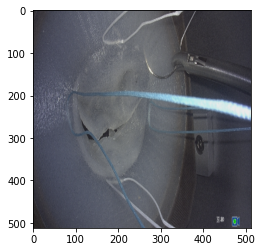

In [28]:
plt.imshow(image)
plt.savefig('./pic/images.png')
plt.show()


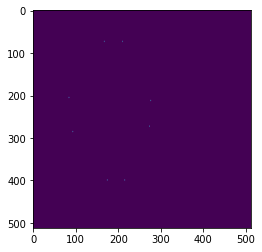

In [29]:
plt.imshow(label)
plt.savefig('./pic/labels.png')
plt.show()

In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def points_to_gaussian_heatmap(centers, height, width, scale):
    if centers:
        gaussians = []
        for x,y in centers:
            s = np.eye(2)*scale
            g = multivariate_normal(mean=(x,y), cov=s)
            gaussians.append(g)

        # create a grid of (x,y) coordinates at which to evaluate the kernels
        x = np.arange(0, width)
        y = np.arange(0, height)
        xx, yy = np.meshgrid(x,y)
        xxyy = np.stack([xx.ravel(), yy.ravel()]).T

        # evaluate kernels at grid points
        zz = sum(g.pdf(xxyy) for g in gaussians)
        img = zz.reshape((height,width))
    else:
        img = np.zeros((height,width))
    return img

def heatmap_generator(file_name, SCALE=64):
    file_in = json.load(open(file_name))
    points = file_in["points"]
    point_outs = []
    height = file_in["imageHeight"]
    width = file_in["imageWidth"]
    img = np.zeros((height,width),dtype = np.uint8)
    for point in points:
        point_out = [point["x"],point["y"]]
        point_outs.append(point_out)
    img = points_to_gaussian_heatmap(point_outs, height, width, SCALE)
    return img

def normalize(image):
    mean = np.mean(image)
    var = np.mean(np.square(image-mean))
    image = (image - mean)/np.sqrt(var)
    return image


(288, 512)


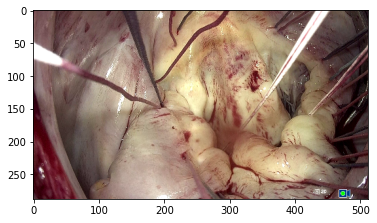

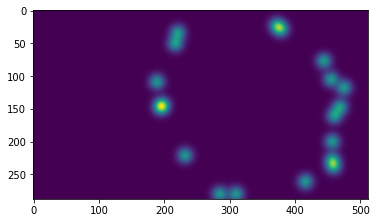

[-2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01 -2.84456888e-01
 -2.84456888e-01 -2.84456

In [29]:
from PIL import Image
import os
base_path = "./Traindata/aicm11/Ch1_008_CH001_V"

image_path = os.path.join(base_path, "images/OR_000095.png")
realimg = Image.open(image_path)
label_path = os.path.join(base_path, "point_labels/OR_000095.json")

img = heatmap_generator(label_path)
img = normalize(img)

print(img.shape)
plt.imshow(realimg); plt.show()
plt.imshow(img); plt.show()
print(img[144])